# M2177.004300 Deep Learning Assignment #1<br> Part 1-2. Training CNNs (Pytorch)

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Jieun Byeon, September 2025

**For understanding of this work, please carefully look at given PDF file.**

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **PyTorch**. <br>
In this notebook, you will learn how to train CNNs for classifying images in the CIFAR-10 dataset. <br>

**<font color=red> Do not clear the outputs </font>**

## 1. Load datasets
The CIFAR-10 dataset will be downloaded automatically if it is not located in the *data* directory. <br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
%pwd # 현재 경로 확인

'/content'

In [4]:
# Assighment1 경로로 이동
%cd /content/drive/MyDrive/Assignment1

[Errno 2] No such file or directory: '/content/drive/MyDrive/Assignment1'
/content


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
g = torch.Generator()
g.manual_seed(seed)

In [ ]:
import torch
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.12), ratio=(0.3, 3.3)),
])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=16,
                                          shuffle=True, num_workers=1, generator=g)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=16,
                                         shuffle=False, num_workers=1, generator=g)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Visualize some samples

In [ ]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

(70, 274, 3)


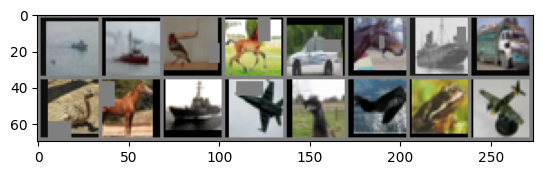

 ship  ship  bird horse
torch.Size([3, 32, 32])


In [ ]:
# get some random training images
images, labels = next(iter(dataloader_train))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# print size of single image
print(images[1].shape)

## 2. Training a small CNN model

#### CNN architecture in order:
* 7x7 Convolutional layer with 8 filters, strides of 1, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* 4x4 Convolutional layer with 16 filters, strides of 1, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* Fully connected layer with 100 output units and ReLU activation
* Fully connected layer with 80 output units and ReLU activation
* Fully connected layer with 10 output units
* You can use any padding option.

#### Training setup:
* Loss function: Softmax cross entropy
* Optimizer: Gradient descent with 0.001 learning rate
* Batch size: 8
* Training epoch: 2

In [ ]:
# Define a CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2, padding = 1)
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=8,
            kernel_size=7,
            stride=1,
            padding=3
        )
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=4,
            stride=1,
            padding=2
        )
        self.fc1 = nn.Linear(16*9*9, 100)
        self.fc2 = nn.Linear(100, 80)
        self.fc3 = nn.Linear(80, 10)
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

    def forward(self, x):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return x


In [ ]:
# Function to train the network

def train(net, dataloader_train, max_epoch, crit, optimizer, device, model_path):

    for epoch in range(max_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader_train, 0):
            # get the inputs; data is a list of [inputs, targets]
            inputs, targets = data

            # Training on GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = crit(outputs, targets)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % (len(dataloader_train) // 2) == (len(dataloader_train) // 2) - 1:
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / (len(dataloader_train) // 2)))
              running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), model_path)
    print('Saved Trained Model')

In [ ]:
PATH = './model_checkpoints/basic_cnn.pt'
epoch = 2

# initialize model
net = Net()

# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train(net, dataloader_train, epoch, criterion, optimizer, device, PATH)

KeyboardInterrupt: 

In [ ]:
# function to calculate accuracy
def print_accuracy(net, dataloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # Inference on GPU
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d test images: %d %%' % (total,
        100 * correct / total))

In [ ]:
# load trained model then test
net.load_state_dict(torch.load(PATH))
print_accuracy(net, dataloader_test)

KeyboardInterrupt: 

## <a name="3-1"></a>3-1. Design an Inception module

In this section, you will implement a little more complex CNN model with an `Inception module`. <br>

![Inception_module](./imgs/Inception.png)

Using the code provided as guidance, <br>
Define an `inception module`, which is the building block of **Inception model (a.k.a GoogLeNet)**, the winner of ILSVRC14. <br>


#### CNN architecture:
* CNN model consists with stem layer, inception module, and fully connected layer
* Stem layer with
    * conv-pooling-conv-pooling
    * 8 filters for the 9x9 convolutions
    * 3x3 max pooling
* `Inception module` with
    * 3(or 4) main convolutions (blue blocks in the Figure(a))
    * 3 dimensionality reduction convolutions (yellow blocks in the Figure(a))
    * 3x3 max pooling block (red blocks in the Figure(a))
    * Batch Nomalization and ReLU activation after all conv layer
* Fully connected layer with 10 output units and linear activation
* Choose the proper padding option on your own.

In [ ]:
'''
About parameter
in_planes : # of input channel
n1xn1 : # of output channel for first branch
n3xn3_blue : # of output channel for second branch's 1x1 conv layer
n3xn3 : # of output channel for second branch
n5xn5_blue : # of output channel for third branch's 1x1 conv layer
n5xn5 : # of output channel for third branch
pool_planes : # of output channel for fourth branch

'''
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3_blue, n3x3, n5x5_blue, n5x5, pool_planes):
        super(Inception, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################

        # 1x1 conv branch

        self.b1 = nn.Sequential(
            nn.Conv2d(
                in_channels = in_planes,
                out_channels = n1x1,
                kernel_size = 1,
                padding = 0
            ),
            nn.BatchNorm2d(n1x1),
            nn.ReLU()
        )

        # 1x1 conv -> 3x3 conv branch

        self.b2 = nn.Sequential(
            nn.Conv2d(
                in_channels = in_planes,
                out_channels = n3x3_blue,
                kernel_size = 1,
                padding = 0
            ),
            nn.Conv2d(
                in_channels = n3x3_blue,
                out_channels = n3x3,
                kernel_size = 3,
                padding = 1
            ),
            nn.BatchNorm2d(n3x3),
            nn.ReLU()
        )

        # 1x1 conv -> 5x5 conv branch

        self.b3 = nn.Sequential(
            nn.Conv2d(
                in_channels = in_planes,
                out_channels = n5x5_blue,
                kernel_size = 1,
                padding = 0
            ),
            nn.Conv2d(
                in_channels = n5x5_blue,
                out_channels = n5x5,
                kernel_size = 5,
                padding = 2
            ),
            nn.BatchNorm2d(n5x5),
            nn.ReLU()
        )

        # 3x3 pool -> 1x1 conv branch

        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(
                        in_channels = in_planes,
                        out_channels = pool_planes,
                        kernel_size = 1,
                        padding = 0
                    ),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(inplace = True)
        )

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

## <a name="3-2"></a>3-2. Design an Residual Block module

In this section, you will implement a little more complex CNN model with a `Residual block`. <br>

![Residual_block](imgs/Residualblock.png)

Using the code provided as guidance, <br>
Define a `residual block module`, which is the building block of **Residual neural network (a.k.a ResNet)**, the winner of ILSVRC15. <br>


#### CNN architecture:
* A residual block consists of convolutional layers, bach normalization, ReLU actication functions, and Shortcut Connection.
* Define the Short Connection which directly connects the input of the block to the output.
* The shortcut module must be sequential layers that contain:
    * 1 convolution of kernel size 1
    * 1 batch normalization layer

In [ ]:


# Define the residual block class
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.relu = nn.ReLU()

        # The first convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # The second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection (identity mapping)
        if stride != 1 or in_channels != out_channels:
            ##############################################################################
            #                        IMPLEMENT OF YOUR CODE                       #
            ##############################################################################
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                        in_channels =in_channels,
                        out_channels = out_channels,
                        kernel_size = 1,
                        stride = stride,
                        padding = 0,
                        bias = False
                ),
                nn.BatchNorm2d(out_channels)
            )
            ##############################################################################
            #                           END OF YOUR CODE                          #
            ##############################################################################
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        # Pass through the first convolutional layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Pass through the second convolutional layer
        out = self.conv2(out)
        out = self.bn2(out)

        # Shortcut connection
        shortcut = self.shortcut(x)

        # Add the output and the shortcut and pass it through a relu activation layer for the final output. (Residual connection implementation)
        ##############################################################################
            #                        IMPLEMENT OF YOUR CODE                       #
        ##############################################################################
        out = self.relu(out + shortcut)
        ##############################################################################
            #                        IMPLEMENT OF YOUR CODE                       #
        ##############################################################################
        return out

## <a name="3-3"></a>3-3. Design a better model on CIFAR-10

Now it's your job to experiment with CNNs to train a model that achieves **<font color=red>>= 75% accuracy on the test set</font>** of CIFAR-10. <br> You can reuse the implemented functions from above.

### Things you can try to change:
- Filter size
- Number of filters
- Pooling vs Strided Convolution
- Network architectures
- Optimizers
- Activation functions
- Regularizations
- Model ensembles
- Data augmentation
- learning rate scheduler

In [ ]:
# Define a CNN model
class BetterNet(nn.Module):
    def __init__(self):
        super(BetterNet, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)

        self.stem1 = nn.Sequential(
            nn.Conv2d(
              in_channels = 3,
              out_channels = 32,
              kernel_size = 3,
              stride = 1,
              padding = 1,
              bias=False
            ),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.stem2 = nn.Sequential(
            nn.Conv2d(
              in_channels = 32,
              out_channels = 32,
              kernel_size = 3,
              stride = 1,
              padding = 1,
              bias=False
            ),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.avgpool = nn.AvgPool2d(kernel_size= 2, stride = 2)
        self.incep1 = Inception(
            in_planes = 8,
            n1x1 = 8,
            n3x3_blue = 12,
            n3x3 = 16,
            n5x5_blue= 4,
            n5x5 = 8,
            pool_planes = 8
            )
        self.incep2 = Inception(40, 16, 24, 32, 8, 16, 16)
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 32, stride=1),
            ResidualBlock(32, 32, stride=1),
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64, stride=2),
            ResidualBlock(64, 64, stride=1),
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128, stride=1),
        )
        self.fc1 = nn.Linear(128, 10)
        # self.fc2 = nn.Linear(100, 80)
        # self.fc3 = nn.Linear(80, 10)
        self.gap = nn.AdaptiveAvgPool2d(1)
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

    def forward(self, x):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        x = self.stem1(x)
        x = self.stem2(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        out = self.fc1(x)
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return out


In [ ]:
# initialize model
betternet = BetterNet()
betternet = betternet.to(device)

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(betternet.parameters(), lr=0.003, weight_decay = 5e-4)


PATH = './model_checkpoints/better_CNN.pth'
# Train
train(betternet, dataloader_train, 20, criterion, optimizer, device, PATH)
# Test
betternet.load_state_dict(torch.load(PATH))
print_accuracy(betternet, dataloader_test)

[1,  1562] loss: 1.890
[1,  3124] loss: 1.509
[2,  1562] loss: 1.256
[2,  3124] loss: 1.121
[3,  1562] loss: 1.001
[3,  3124] loss: 0.914
[4,  1562] loss: 0.825
[4,  3124] loss: 0.774
[5,  1562] loss: 0.719
[5,  3124] loss: 0.670
[6,  1562] loss: 0.645
[6,  3124] loss: 0.624
[7,  1562] loss: 0.594
[7,  3124] loss: 0.582
[8,  1562] loss: 0.542
[8,  3124] loss: 0.551
[9,  1562] loss: 0.515
[9,  3124] loss: 0.506
[10,  1562] loss: 0.485
[10,  3124] loss: 0.481
[11,  1562] loss: 0.456
[11,  3124] loss: 0.455
[12,  1562] loss: 0.427
[12,  3124] loss: 0.436
[13,  1562] loss: 0.410
[13,  3124] loss: 0.418
[14,  1562] loss: 0.380
[14,  3124] loss: 0.400
[15,  1562] loss: 0.378
[15,  3124] loss: 0.385
[16,  1562] loss: 0.368
[16,  3124] loss: 0.373
[17,  1562] loss: 0.349
[17,  3124] loss: 0.361
[18,  1562] loss: 0.335
[18,  3124] loss: 0.351
[19,  1562] loss: 0.326
[19,  3124] loss: 0.338
[20,  1562] loss: 0.313
[20,  3124] loss: 0.328
Finished Training
Saved Trained Model
Accuracy of the netw

### Describe what you did for better_CNN here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

You can write in Korean

Residual 모델 사용

데이터 증강 : 크롭, 좌우 반전, 밝기, 대비, 채도 조절, 사각형 영역 지움(약한 정도의 증강) -> 노이즈에 더 강한 모델

stem : 3 > 32 channel로 3x3 conv, 32 > 32로 3x3 conv -> 9x9는 너무 광범위해 줄임

layer : Redsidual 블럭 두개를 묶어서 하나의 레이어로 구성. 첫 레이어는 채널을 유지하면서 작은 특징, 두개의 레이어는 채널을 두배로 늘리면서 큰 특징 잡기

gap, flatten : 공간축에 대해 평균을 내서 채널에 대한 정보값남 남기기 -> CIFAR는 작은 이미지이므로 8x8 공간 정보를 남겨둘 필요성이 작음. 또한 fc 파라미터 개수를 줄여 과적합 방지, 속도 향상

dropout : p = 0.2로 regularization

fc : 128 > 10으로 mapping해 결과출력